# DATA PROCESSING

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KDTree
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.neighbors import KDTree
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime
from functools import reduce
import matplotlib.pyplot as plt
import gc

In [ ]:

# Load the dataset
df = pd.read_parquet("merged_ocean_data.parquet")

# Data columns to analyze
data_columns = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

# ============================
# Section 1: Basic Overview
# ============================
print("\nBASIC INFO")
print(f"Total rows               : {len(df):,}")
print(f"Total columns            : {df.shape[1]}")
print(f"Date range               : {df['time'].min()} → {df['time'].max()}")
print(f"Unique dates             : {df['time'].dt.date.nunique()}")
print(f"Unique latitudes         : {df['latitude'].nunique()}")
print(f"Unique longitudes        : {df['longitude'].nunique()}")
print(f"Unique (lat, lon) pairs  : {df[['latitude', 'longitude']].drop_duplicates().shape[0]}")

# ============================
# Section 2: Variable Summary
# ============================
print("\nVARIABLE SUMMARY")
summary = []

for col in data_columns:
    col_data = df[col]
    summary.append({
        'Variable': col,
        'NaN count': col_data.isna().sum(),
        '-1 (Land)': (col_data == -1).sum(),
        '-2 (Missing fill)': (col_data == -2).sum(),
        'Valid values': ((col_data != -1) & (col_data != -2) & (~col_data.isna())).sum(),
        'Min': col_data.min(skipna=True),
        'Max': col_data.max(skipna=True),
        'Mean': col_data.mean(skipna=True)
    })

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

# ============================
# Section 3: Rows per Date
# ============================
print("\nROWS PER DATE SUMMARY")
date_counts = df['time'].dt.date.value_counts().sort_index()
print(f"Total unique dates : {len(date_counts)}")
print(f"Min rows/day       : {date_counts.min():,}")
print(f"Max rows/day       : {date_counts.max():,}")
print(f"Avg rows/day       : {int(date_counts.mean()):,}")


BASIC INFO
Total rows               : 187,545,406
Total columns            : 15
Date range               : 2023-01-01 00:00:00 → 2024-12-31 00:00:00
Unique dates             : 731
Unique latitudes         : 298
Unique longitudes        : 827
Unique (lat, lon) pairs  : 246446

VARIABLE SUMMARY
Variable  NaN count  -1 (Land)  -2 (Missing fill)  Valid values       Min       Max      Mean
   KD490  130455744          0                  0      57089662  0.023318  1.279428  0.091025
     ZSD  130455744          0                  0      57089662  1.323802 52.423088 11.028897
  RRS490  135491294          0                  0      52054112 -0.001804  0.062009  0.004803
  RRS443  135491294          0                  0      52054112 -0.004186  0.060021  0.004430
     CHL  130455744          0                  0      57089662  0.026318 64.051796  1.075825
   MICRO  153820540          0                  0      33724866  0.005000 50.000000  1.373300
     BBP  144061335          0                 

In [ ]:

# SECTION 1: LOAD & CLEAN DATA

input_path = "/Users/sharma.adarsh/Downloads/merged_ocean_data.parquet"
df = pd.read_parquet(input_path)

columns_to_check = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']
cols_to_remove = ['flags_optics', 'flags_reflectance', 'flags_transparency']
df = df.drop(columns=cols_to_remove, errors='ignore')

print(f"Loaded: {len(df):,} rows")
df.loc[df['flags'] == 1, columns_to_check] = -1  # Mark land data with -1

Loaded: 187,545,406 rows


In [ ]:

# SECTION 2: MARK LONG NaN STREAKS

print("Marking long NaN streaks (>15 days) with -10...")
df.sort_values(by=['latitude', 'longitude', 'time'], inplace=True)
streak_indices = defaultdict(list)
THRESHOLD = 15

for (lat, lon), group in tqdm(df.groupby(['latitude', 'longitude']), desc="Streak marking"):
    for col in columns_to_check:
        is_nan = (group[col].isna()) & (group[col] != -1)
        streak_ids = (is_nan != is_nan.shift()).cumsum()
        streak_lengths = is_nan.groupby(streak_ids).sum()
        for k, length in streak_lengths.items():
            if length >= THRESHOLD:
                streak_indices[col].extend(group[streak_ids == k].index)

for col, idxs in streak_indices.items():
    df.loc[idxs, col] = -10.0

Marking long NaN streaks (>15 days) with -10...


Streak marking: 100%|██████████| 246446/246446 [17:29<00:00, 234.85it/s]


In [ ]:

# SECTION 3: TEMPORAL FORWARD FILL

print("Forward filling temporally...")
df[columns_to_check] = df.groupby(['latitude', 'longitude'])[columns_to_check].ffill()

# Replace -10 back to NaN before spatial fill
df[columns_to_check] = df[columns_to_check].replace(-10.0, np.nan)


Forward filling temporally...


In [ ]:

# SECTION 4: SPATIAL FILL PER DATE

print("Spatial interpolation using KDTree...")
df['date'] = df['time'].dt.date
filled_dfs = []

for date, group in tqdm(df.groupby('date'), desc="Spatial fill per day"):
    filled_group = group.copy()
    coords = group[['latitude', 'longitude']].values

    for col in columns_to_check:
        missing_mask = group[col].isna() & (group[col] != -1)
        if not missing_mask.any():
            continue
        known_mask = (~group[col].isna()) & (group[col] != -1)
        if not known_mask.any():
            filled_group.loc[missing_mask, col] = -2
            continue

        known_coords = coords[known_mask]
        known_values = group.loc[known_mask, col].values
        tree = KDTree(known_coords)
        dist, idx = tree.query(coords[missing_mask], k=1)
        filled_group.loc[missing_mask, col] = known_values[idx.flatten()]

    filled_dfs.append(filled_group)

df_filled = pd.concat(filled_dfs)
print("Spatial fill complete.")


Spatial interpolation using KDTree...


Spatial fill per day: 100%|██████████| 731/731 [03:40<00:00,  3.32it/s]


Spatial fill complete.


In [ ]:

# SECTION 5: FINAL NaN CHECK + SAVE CLEANED 1KM

print("\n Final missing value check...")
missing_total = df_filled[columns_to_check].isna().sum().sum()
if missing_total == 0:
    print("No missing values remaining.")
else:
    print(f"{missing_total} missing values still remain. Investigate further.")

# Save filled 1km data
filled_path = "fully_cleaned_filled_data.parquet"
df_filled.to_parquet(filled_path, index=False)
print(f"Saved fully filled 1km data to: {filled_path}")


 Final missing value check...
No missing values remaining.
Saved fully filled 1km data to: fully_cleaned_filled_data.parquet


In [ ]:

# SECTION 6: TURBO 5KM DOWNSAMPLING (FIXED)



print("\nStarting 5km downsampling...")

res_deg = 0.05  # ~5km ≈ 0.05 degrees
df_filled['lat_5km'] = (df_filled['latitude'] / res_deg).round() * res_deg
df_filled['lon_5km'] = (df_filled['longitude'] / res_deg).round() * res_deg

data_columns = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']
group_cols = ['lat_5km', 'lon_5km']
result_chunks = []

for date, group in tqdm(df_filled.groupby('date', sort=False), total=df_filled['date'].nunique(), desc="TURBO 5km"):
    group = group.copy()
   
    # STEP 1: Compute valid means only
    valid_mask = (group[data_columns] != -1) & (group[data_columns] != -2)
    valid_values = group[data_columns].where(valid_mask)
    numeric_means = valid_values.groupby([group['lat_5km'], group['lon_5km']], sort=False).mean()

    # STEP 2: Compute fallback values efficiently (vectorized)
    fallback = pd.DataFrame(index=numeric_means.index, columns=data_columns)

    for col in data_columns:
        is_valid = ((group[col] != -1) & (group[col] != -2)).astype(int)
        is_missing = (group[col] == -2).astype(int)

        valid_count = is_valid.groupby([group['lat_5km'], group['lon_5km']], sort=False).sum()
        missing_count = is_missing.groupby([group['lat_5km'], group['lon_5km']], sort=False).sum()

        fallback_col = pd.Series(index=numeric_means.index, dtype="float32")
        fallback_col.loc[valid_count == 0] = -1
        fallback_col.loc[(valid_count == 0) & (missing_count > 0)] = -2
        fallback[col] = fallback_col

    # STEP 3: Merge numeric means with fallback
    numeric_final = numeric_means.copy()
    for col in data_columns:
        numeric_final[col] = numeric_final[col].fillna(fallback[col])

    # STEP 4: Metadata aggregation
    meta = group.groupby(group_cols, sort=False).agg({
        'time': 'first',
        'flags': lambda x: x.mode().iloc[0] if not x.mode().empty else 1
    })

    # STEP 5: Combine numeric + metadata
    result = pd.concat([numeric_final, meta], axis=1).reset_index()
    result['date'] = date
    result_chunks.append(result)

# Final concatenation
df_5km = pd.concat(result_chunks, ignore_index=True)


Starting 5km downsampling...


TURBO 5km: 100%|██████████| 731/731 [10:40<00:00,  1.14it/s]


In [ ]:

# SAVE FINAL 5KM DATA

df_5km.to_parquet("spatially_filled_data_5km.parquet", index=False)
print(f"\n5km data saved: spatially_filled_data_5km.parquet")
print(df_5km.info())
	


5km data saved: spatially_filled_data_5km.parquet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7967169 entries, 0 to 7967168
Data columns (total 13 columns):
 #   Column   Dtype         
---  ------   -----         
 0   lat_5km  float32       
 1   lon_5km  float32       
 2   KD490    float32       
 3   ZSD      float32       
 4   RRS490   float32       
 5   RRS443   float32       
 6   CHL      float32       
 7   MICRO    float32       
 8   BBP      float32       
 9   CDM      float32       
 10  time     datetime64[ns]
 11  flags    float32       
 12  date     object        
dtypes: datetime64[ns](1), float32(11), object(1)
memory usage: 455.9+ MB
None


In [ ]:

print("\nStarting 5km downsampling from downloaded spatially filled data...")

# LOAD SPATIALLY FILLED DATA



df_filled = pd.read_parquet("fully_cleaned_filled_data.parquet")  # update path if needed


# CONFIGURATION



res_deg = 0.05  # ~5km ≈ 0.05 degrees
data_columns = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']
group_cols = ['lat_5km', 'lon_5km']
result_chunks = []



# STEP 1: SPATIAL BINNING (clean and precise)

df_filled['lat_5km'] = df_filled['latitude'].div(res_deg).round().mul(res_deg).round(2)
df_filled['lon_5km'] = df_filled['longitude'].div(res_deg).round().mul(res_deg).round(2)

# Force float precision (optional but avoids artifacts)
df_filled['lat_5km'] = df_filled['lat_5km'].astype(np.float32)
df_filled['lon_5km'] = df_filled['lon_5km'].astype(np.float32)

# STEP 2: Sanity Check



df_filled = df_filled.dropna(subset=['lat_5km', 'lon_5km']).reset_index(drop=True)



# STEP 3: DOWNSAMPLE DAILY

for date, group in tqdm(df_filled.groupby('date', sort=False), total=df_filled['date'].nunique(), desc=" Downsampling"):
    group = group.copy()

    # VALID MASK (exclude land (-1) and fully missing (-2))
    valid_mask = (group[data_columns] != -1) & (group[data_columns] != -2)
    valid_values = group[data_columns].where(valid_mask)

    # STEP 3.1: MEAN of valid values
    numeric_means = valid_values.groupby([group['lat_5km'], group['lon_5km']], sort=False).mean()

    # STEP 3.2: FALLBACK for all-missing or all-land pixels
    fallback = pd.DataFrame(index=numeric_means.index, columns=data_columns)
    for col in data_columns:
        is_valid = ((group[col] != -1) & (group[col] != -2)).astype(int)
        is_missing = (group[col] == -2).astype(int)

        valid_count = is_valid.groupby([group['lat_5km'], group['lon_5km']], sort=False).sum()
        missing_count = is_missing.groupby([group['lat_5km'], group['lon_5km']], sort=False).sum()

        fallback_col = pd.Series(index=numeric_means.index, dtype="float32")
        fallback_col.loc[valid_count == 0] = -1  # all land
        fallback_col.loc[(valid_count == 0) & (missing_count > 0)] = -2  # all missing
        fallback[col] = fallback_col

    numeric_final = numeric_means.copy()
    for col in data_columns:
        numeric_final[col] = numeric_final[col].fillna(fallback[col])

    # STEP 3.3: METADATA aggregation
    meta = group.groupby(group_cols, sort=False).agg({
        'time': 'first',
        'flags': lambda x: x.mode().iloc[0] if not x.mode().empty else 1
    })

    # STEP 3.4: COMBINE and TAG DATE
    result = pd.concat([numeric_final, meta], axis=1).reset_index()
    result['date'] = date
    result_chunks.append(result)


# STEP 4: CONCATENATE AND SAVE

df_5km = pd.concat(result_chunks, ignore_index=True)

output_path = "spatially_filled_data_5km_cleaned2.parquet"
df_5km.to_parquet(output_path, index=False)
print(f"\nCleaned 5km file saved: {output_path}")



Starting 5km downsampling from downloaded spatially filled data...


 Downsampling: 100%|██████████| 731/731 [09:51<00:00,  1.24it/s]



Cleaned 5km file saved: spatially_filled_data_5km_cleaned2.parquet


In [9]:
import pandas as pd

# Load the spatially downsampled file
df_5km = pd.read_parquet('spatially_filled_data_5km_cleaned2.parquet')

# Fix lat_5km and lon_5km to exactly 2 decimal places
df_5km['lat_5km'] = df_5km['lat_5km'].apply(lambda x: float(f"{x:.2f}"))
df_5km['lon_5km'] = df_5km['lon_5km'].apply(lambda x: float(f"{x:.2f}"))

# Save the cleaned version
cleaned_file_path = "spatially_filled_data_5km_cleaned_with_decimal_fixed.parquet"
df_5km.to_parquet(cleaned_file_path, index=False)

# Display a few rows to confirm the fix
df_5km[['lat_5km', 'lon_5km']].drop_duplicates().sort_values(['lat_5km', 'lon_5km']).head(10)


,lat_5km,lon_5km
0,49.15,-10.75
1,49.15,-10.70
2,49.15,-10.65
3,49.15,-10.60
4,49.15,-10.55
5,49.15,-10.50
6,49.15,-10.45
7,49.15,-10.40
8,49.15,-10.35
9,49.15,-10.30


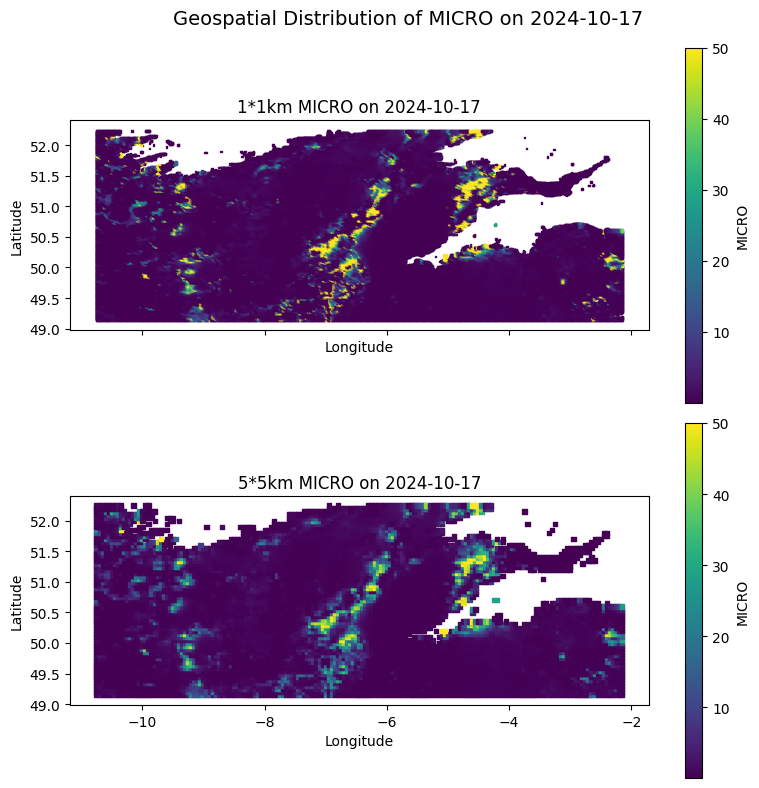

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# ================================
# CONFIGURATION
# ================================
target_date = pd.to_datetime("2024-10-17").date()
var = 'MICRO'

# ================================
# LOAD DATA
# ================================
df_1km = pd.read_parquet("fully_cleaned_filled_data.parquet")
df_5km = pd.read_parquet("spatially_filled_data_5km_cleaned_with_decimal_fixed.parquet")

# ================================
# FILTER TO TARGET DATE
# ================================
df_1km_day = df_1km[df_1km['date'] == target_date]
df_5km_day = df_5km[df_5km['date'] == target_date]

# ================================
# REMOVE LAND DATA (-1)
# ================================
df_1km_day = df_1km_day[df_1km_day[var] != -1]
df_5km_day = df_5km_day[df_5km_day[var] != -1]

# ================================
# SHARED COLOR RANGE
# ================================
vmin = min(df_1km_day[var].min(), df_5km_day[var].min())
vmax = max(df_1km_day[var].max(), df_5km_day[var].max())

# ================================
# PLOTTING
# ================================
fig, axs = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

# 1KM PLOT
sc1 = axs[0].scatter(df_1km_day['longitude'], df_1km_day['latitude'], c=df_1km_day[var],
                     cmap='viridis', s=1, marker='s', vmin=vmin, vmax=vmax)
axs[0].set_title(f"1*1km {var} on {target_date}")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
fig.colorbar(sc1, ax=axs[0], orientation='vertical', label=var)

# 5KM PLOT
sc2 = axs[1].scatter(df_5km_day['lon_5km'], df_5km_day['lat_5km'], c=df_5km_day[var],
                     cmap='viridis', s=10, marker='s', vmin=vmin, vmax=vmax)
axs[1].set_title(f"5*5km {var} on {target_date}")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")
fig.colorbar(sc2, ax=axs[1], orientation='vertical', label=var)

# Set aspect ratio equal for both
for ax in axs:
    ax.set_aspect('equal')

plt.suptitle(f"Geospatial Distribution of {var} on {target_date}", fontsize=14)
plt.tight_layout()
plt.show()
